In [2]:
import random
import sys

import importlib
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, metrics
from imblearn.over_sampling import SMOTE

import data_visualisation as dv
import data_augmentation as da

2024-05-31 16:22:07.685113: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-31 16:22:08.136696: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-05-31 16:22:08.136754: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-05-31 16:22:08.136761: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

# Load the Data

In [3]:
thismodule = sys.modules[__name__]
# NP_DATA = 'data/DAT_China.npz'
NP_DATA = 'data/DAT_China_1s.npz'

with np.load(NP_DATA, allow_pickle=True) as data:
    for k in data.keys():
        if 'text' in k:
            setattr(thismodule, k, data[k])
        else:
            setattr(thismodule, k, data[k].astype(float))
            
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
print(folds_train.shape)

# convert the labels to binary
Y_train = np.where(Y_train == 1, True, False)
Y_test = np.where(Y_test == 1, True, False)

(8386, 100, 12) (8386,)
(2159, 100, 12) (2159,)
(8386,)


In [12]:
# label dist of each fold
for i in range(8):
    # size of each fold
    print(f'Fold {i} size: {X_train[folds_train == i].shape[0]}')
    # no of true labels in each fold
    print(f'Fold {i} true labels: {np.sum(Y_train[folds_train == i])}')

Fold 0 size: 1114
Fold 0 true labels: 221
Fold 1 size: 1053
Fold 1 true labels: 263
Fold 2 size: 1058
Fold 2 true labels: 295
Fold 3 size: 968
Fold 3 true labels: 335
Fold 4 size: 1019
Fold 4 true labels: 208
Fold 5 size: 1049
Fold 5 true labels: 240
Fold 6 size: 1030
Fold 6 true labels: 214
Fold 7 size: 1095
Fold 7 true labels: 338


# SMOTE

In [27]:
# smote per fold

# empty arrays to store the resampled data of shape (0, 100, 12)
Resampled_X_train = np.array([], dtype=np.float32).reshape(0, 100, 12)
Resampled_Y_train = np.array([], dtype=bool).reshape(0,)
Resampled_folds_train = np.array([], dtype=int).reshape(0,)

for k in range(8):
    # get the fold samples + labels
    X_fold = X_train[folds_train == k]
    Y_fold = Y_train[folds_train == k]
    X_fold_flattened = X_fold.reshape((X_fold.shape[0], -1))
    
    # resample the fold
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_resampled_fold_flattened, y_resampled_fold = smote.fit_resample(X_fold_flattened, Y_fold)
    X_resampled_fold = X_resampled_fold_flattened.reshape((-1, 100, 12))
    
    folds = np.full((X_resampled_fold.shape[0],), k)

    print(f"\nFold {k} shape:           {X_fold.shape}")
    print(f"Resampled Fold {k} shape: {X_resampled_fold.shape}")
    print(f"Fold {k} class distribution:           {np.bincount(Y_fold)}")
    print(f"Resampled Fold {k} class distribution: {np.bincount(y_resampled_fold)}")

    
    # concatenate the resampled fold with the original data
    Resampled_X_train = np.concatenate([Resampled_X_train, X_resampled_fold])
    Resampled_Y_train = np.concatenate([Resampled_Y_train, y_resampled_fold])
    Resampled_folds_train = np.concatenate([Resampled_folds_train, folds])
    
    
print(X_train.shape, Y_train.shape, folds_train.shape)
print(Resampled_X_train.shape, Resampled_Y_train.shape, Resampled_folds_train.shape)

[0 0 0 ... 0 0 0]

Fold 0 shape:           (1114, 100, 12)
Resampled Fold 0 shape: (1786, 100, 12)
Fold 0 class distribution:           [893 221]
Resampled Fold 0 class distribution: [893 893]
[1 1 1 ... 1 1 1]

Fold 1 shape:           (1053, 100, 12)
Resampled Fold 1 shape: (1580, 100, 12)
Fold 1 class distribution:           [790 263]
Resampled Fold 1 class distribution: [790 790]
[2 2 2 ... 2 2 2]

Fold 2 shape:           (1058, 100, 12)
Resampled Fold 2 shape: (1526, 100, 12)
Fold 2 class distribution:           [763 295]
Resampled Fold 2 class distribution: [763 763]
[3 3 3 ... 3 3 3]

Fold 3 shape:           (968, 100, 12)
Resampled Fold 3 shape: (1266, 100, 12)
Fold 3 class distribution:           [633 335]
Resampled Fold 3 class distribution: [633 633]
[4 4 4 ... 4 4 4]

Fold 4 shape:           (1019, 100, 12)
Resampled Fold 4 shape: (1622, 100, 12)
Fold 4 class distribution:           [811 208]
Resampled Fold 4 class distribution: [811 811]
[5 5 5 ... 5 5 5]

Fold 5 shape:    

In [28]:
# label dist of each fold
for i in range(8):
    # size of each fold
    print(f'Fold {i} size: {Resampled_X_train[Resampled_folds_train == i].shape[0]}')
    # no of true labels in each fold
    print(f'Fold {i} true labels: {np.sum(Resampled_Y_train[Resampled_folds_train == i])}')

Fold 0 size: 1786
Fold 0 true labels: 893
Fold 1 size: 1580
Fold 1 true labels: 790
Fold 2 size: 1526
Fold 2 true labels: 763
Fold 3 size: 1266
Fold 3 true labels: 633
Fold 4 size: 1622
Fold 4 true labels: 811
Fold 5 size: 1618
Fold 5 true labels: 809
Fold 6 size: 1632
Fold 6 true labels: 816
Fold 7 size: 1514
Fold 7 true labels: 757


In [29]:
# save the resampled data per fold
np.savez_compressed('data/DAT_China_1s_resampled_per_fold.npz',
                    X_train=X_train, Y_train=Y_train,
                    X_train_resampled=Resampled_X_train, Y_train_resampled=Resampled_Y_train,
                    folds_train=folds_train,
                    folds_train_resampled=Resampled_folds_train,
                    X_test=X_test, Y_test=Y_test)

In [5]:
# load the resampled data
thismodule = sys.modules[__name__]
NP_DATA = 'data/DAT_China_1s_resampled.npz'
with np.load(NP_DATA, allow_pickle=True) as data:
    for k in data.keys():
        if 'text' in k:
            setattr(thismodule, k, data[k])
        else:
            setattr(thismodule, k, data[k].astype(float))
            
# convert the labels to binary
Y_train = np.where(Y_train == 1, True, False)
Y_test = np.where(Y_test == 1, True, False)
            
print(X_train.shape, Y_train.shape, folds_train.shape)
print(X_test.shape, Y_test.shape)

(12544, 100, 12) (12544,) (12544,)
(2159, 100, 12) (2159,)


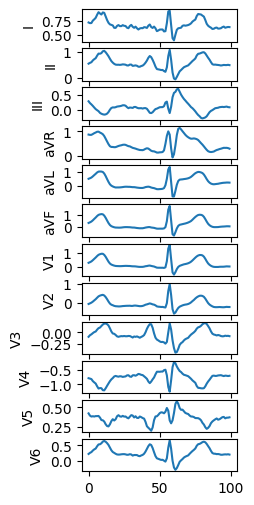

In [14]:
# visualise the data

# get train data where label is 1
X_train_positive = X_train[Y_train]

# plot a random sample
random_sample = random.choice(X_train_positive)
dv.plot_12_lead_ecg(random_sample)

# Training Autoencoder for Deep SMOTE

In [80]:
def encoder(inputs, latent_dim):
    # 100 x 12
    X = layers.Conv1D(24, 5, activation='linear', padding='same', name='conv1')(inputs)
    X = layers.LeakyReLU(alpha=0.3)(X)
    X = layers.BatchNormalization()(X)
    # 100 x 24
    X = layers.MaxPooling1D(2, padding='same')(X)
    X = layers.Dropout(0.3)(X)
    # 50 x 24
    X = layers.Conv1D(48, 5, activation='linear', padding='same', name='conv2')(X)
    X = layers.LeakyReLU(alpha=0.3)(X)
    X = layers.BatchNormalization()(X)
    # 50 x 48
    X = layers.MaxPooling1D(2, padding='same')(X)
    X = layers.Dropout(0.3)(X)
    # 25 x 48
    X = layers.Conv1D(64, 5, activation='linear', padding='same', name='conv3')(X)
    X = layers.LeakyReLU(alpha=0.3)(X)
    X = layers.BatchNormalization()(X)
    # 25 x 64
    X = layers.MaxPooling1D(2, padding='same')(X)
    X = layers.Dropout(0.3)(X)
    # 13 x 64
    X = layers.Flatten()(X)
    # 832
    X = layers.Dense(latent_dim, activation='linear', name='dense-encode')(X)
    X = layers.LeakyReLU(alpha=0.3)(X)
    return X

def decoder(latent_rep, latent_dim):
    X = layers.Dense(13*64, activation='linear', name='dense-decode')(latent_rep)
    X = layers.LeakyReLU(alpha=0.3)(X)
    X = layers.Reshape((13, 64))(X)
    # 13 x 64
    X = layers.UpSampling1D(2)(X)
    # 26 x 64
    X = layers.Conv1DTranspose(48, 5, activation='linear', padding='same', name='upconv1')(X)
    X = layers.LeakyReLU(alpha=0.3)(X)
    X = layers.BatchNormalization()(X)
    # 26 x 48
    X = layers.UpSampling1D(2)(X)
    # 52 x 48
    X = layers.Conv1DTranspose(24, 5, activation='linear', padding='same', name='upconv2')(X)
    X = layers.LeakyReLU(alpha=0.3)(X)
    X = layers.BatchNormalization()(X)
    # 52 x 24
    X = layers.UpSampling1D(2)(X)
    # 104 x 24
    X = layers.Conv1DTranspose(12, 5, activation='linear', padding='same', name='upconv3')(X)
    # 104 x 12
    X = layers.Cropping1D(cropping=(2, 2))(X)  # Cropping to get back to original input size
    # 100 x 12
    return X

def make_model(inputs, latent_dim):
    latent_rep = encoder(inputs, latent_dim)
    X = decoder(latent_rep, latent_dim)
    return keras.Model(inputs=inputs, outputs=X)
    
inputs = keras.Input(shape=X_train.shape[1:])
model = make_model(inputs, latent_dim=256)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer='adam', loss='mse')
model.summary()

model.load_weights('temp/ae_10_epochs_ft_with_augment.h5')


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100, 12)]         0         
                                                                 
 conv1 (Conv1D)              (None, 100, 24)           1464      
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 100, 24)           0         
                                                                 
 batch_normalization_10 (Bat  (None, 100, 24)          96        
 chNormalization)                                                
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 50, 24)           0         
 1D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 50, 24)            0   

In [7]:
# Split the data into training and validation sets
X_train_data = X_train
X_val_data = X_test

# Create tf.data.Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_data, X_train_data))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_data, X_val_data))

# Shuffle and batch the datasets
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

In [66]:
model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
263/263 [==============================] - 2s 8ms/step - loss: 0.1442 - val_loss: 0.2859
Epoch 2/10
263/263 [==============================] - 2s 8ms/step - loss: 0.1207 - val_loss: 0.1542
Epoch 3/10
263/263 [==============================] - 2s 8ms/step - loss: 0.1413 - val_loss: 0.3822
Epoch 4/10
263/263 [==============================] - 2s 8ms/step - loss: 0.1742 - val_loss: 0.1899
Epoch 5/10
263/263 [==============================] - 2s 8ms/step - loss: 0.1044 - val_loss: 0.1506
Epoch 6/10
263/263 [==============================] - 2s 8ms/step - loss: 0.1767 - val_loss: 0.2667
Epoch 7/10
263/263 [==============================] - 2s 9ms/step - loss: 0.2105 - val_loss: 0.1730
Epoch 8/10
263/263 [==============================] - 2s 9ms/step - loss: 0.1296 - val_loss: 0.1435
Epoch 9/10
263/263 [==============================] - 2s 9ms/step - loss: 0.1078 - val_loss: 0.1785
Epoch 10/10
263/263 [==============================] - 2s 9ms/step - loss: 0.1077 - val_loss: 0.1573

In [14]:
def mask_lead(ecg, mask_ratio=0.1):
    batch_size = tf.shape(ecg)[0]
    time_steps = ecg.shape[1]
    num_leads = ecg.shape[2]

    mask = tf.random.uniform([batch_size, num_leads], minval=0, maxval=1) > mask_ratio
    mask = tf.tile(mask[:, tf.newaxis, :], [1, time_steps, 1])
    mask = tf.cast(mask, tf.float32)
    ecg = tf.cast(ecg, tf.float32)
    return ecg * mask

In [57]:
train_dataset = train_dataset.map(lambda x, y: (mask_lead(x, mask_ratio=0.3), y))

In [77]:
model.save('temp/ae_brugada_ft.h5')

(100, 12)
(None, 100, 12)
1/1 [==============================] - 0s 11ms/step


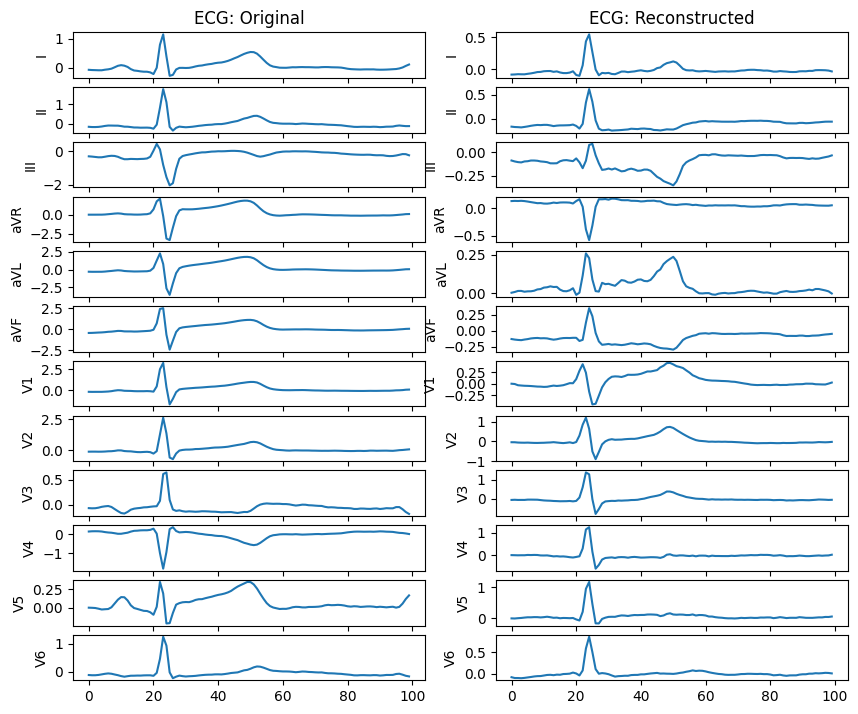

In [111]:
random_sample = random.choice(X_test)
print(random_sample.shape)
print(inputs.shape)

reconstructed_sample = model.predict(random_sample[None, ...])[0]

dv.plot_12_lead_ecgs([random_sample, reconstructed_sample], ['Original', 'Reconstructed'])


In [42]:
# load BARD data
# load Data
import sys
thismodule = sys.modules[__name__]

with np.load('data/BARD.npz', allow_pickle=True) as data:
    for k in data.keys():
        setattr(thismodule, k, data[k])
            
print(ecgs.shape, ecgs_HB.shape, ecgs_HB_patients.shape, ecgs_HB_samples.shape)

(717,) (14751, 100, 12) (14751,) (14751,)


In [26]:
no_of_samples = ecgs_HB.shape[0]
cutoff = int(no_of_samples * 0.8)

# Split the data into training and validation sets
X_train_data_bard = ecgs_HB[:cutoff]
X_val_data_bard = ecgs_HB[cutoff:]

# Create tf.data.Datasets
train_dataset_bard = tf.data.Dataset.from_tensor_slices((X_train_data_bard, X_train_data_bard))
val_dataset_bard = tf.data.Dataset.from_tensor_slices((X_val_data_bard, X_val_data_bard))

# Shuffle and batch the datasets
batch_size = 32
train_dataset_bard = train_dataset_bard.shuffle(buffer_size=1024).batch(batch_size)
val_dataset_bard = val_dataset_bard.batch(batch_size)

# map augmentations
train_dataset_bard = train_dataset_bard.map(lambda x, y: (mask_lead(x, mask_ratio=0.1), y))

In [30]:
model.fit(train_dataset_bard, epochs=10, validation_data=val_dataset_bard)

Epoch 1/10
369/369 [==============================] - 3s 9ms/step - loss: 0.1735 - val_loss: 0.0659
Epoch 2/10
369/369 [==============================] - 3s 8ms/step - loss: 0.1143 - val_loss: 0.0629
Epoch 3/10
369/369 [==============================] - 3s 8ms/step - loss: 0.1071 - val_loss: 0.0544
Epoch 4/10
369/369 [==============================] - 3s 8ms/step - loss: 0.0965 - val_loss: 0.0491
Epoch 5/10
369/369 [==============================] - 3s 8ms/step - loss: 0.0957 - val_loss: 0.0475
Epoch 6/10
369/369 [==============================] - 3s 8ms/step - loss: 0.0883 - val_loss: 0.0450
Epoch 7/10
369/369 [==============================] - 3s 9ms/step - loss: 0.0870 - val_loss: 0.0433
Epoch 8/10
369/369 [==============================] - 3s 9ms/step - loss: 0.0849 - val_loss: 0.0407
Epoch 9/10
369/369 [==============================] - 3s 9ms/step - loss: 0.0826 - val_loss: 0.0407
Epoch 10/10
369/369 [==============================] - 3s 8ms/step - loss: 0.0804 - val_loss: 0.0401

(100, 12)
(None, 100, 12)
1/1 [==============================] - 0s 12ms/step


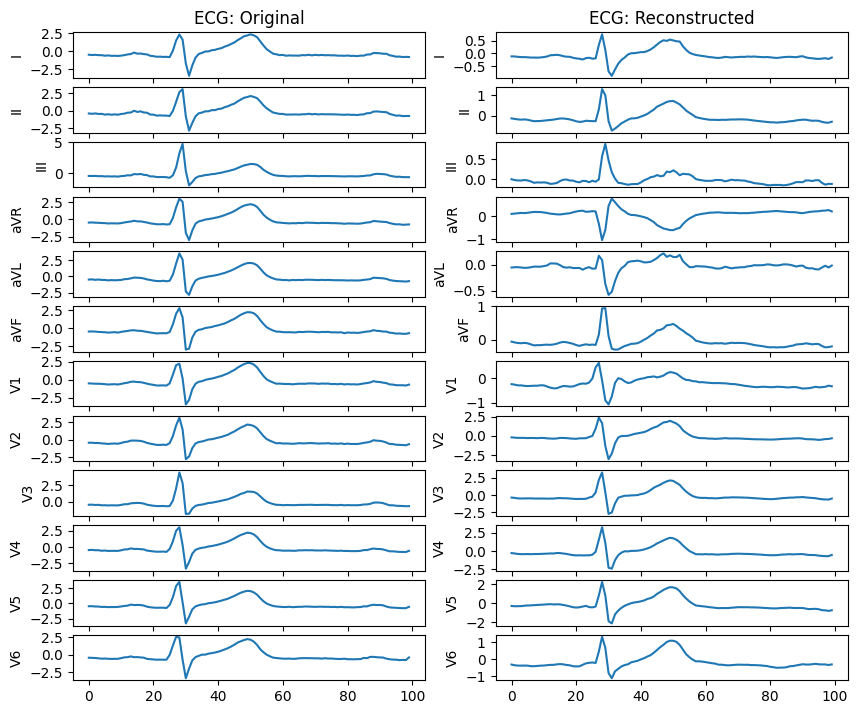

In [108]:
random_sample = random.choice(ecgs_HB)
print(random_sample.shape)
print(inputs.shape)

reconstructed_sample = model.predict(random_sample[None, ...])[0]

dv.plot_12_lead_ecgs([random_sample, reconstructed_sample], ['Original', 'Reconstructed'])


# Deep SMOTE

input_65 input_4
conv1 conv1
leaky_re_lu_231 leaky_re_lu_14
batch_normalization_165 batch_normalization_10
max_pooling1d_99 max_pooling1d_6
dropout_99 dropout_6
conv2 conv2
leaky_re_lu_232 leaky_re_lu_15
batch_normalization_166 batch_normalization_11
max_pooling1d_100 max_pooling1d_7
dropout_100 dropout_7
conv3 conv3
leaky_re_lu_233 leaky_re_lu_16
batch_normalization_167 batch_normalization_12
max_pooling1d_101 max_pooling1d_8
dropout_101 dropout_8
flatten_33 flatten_2
dense-encode dense-encode
leaky_re_lu_234 leaky_re_lu_17
19
dense-decode dense-decode
20
leaky_re_lu_235 leaky_re_lu_18
21
reshape_33 reshape_2
22
up_sampling1d_99 up_sampling1d_6
23
upconv1 upconv1
24
leaky_re_lu_236 leaky_re_lu_19
25
batch_normalization_168 batch_normalization_13
26
up_sampling1d_100 up_sampling1d_7
27
upconv2 upconv2
28
leaky_re_lu_237 leaky_re_lu_20
29
batch_normalization_169 batch_normalization_14
30
up_sampling1d_101 up_sampling1d_8
31
upconv3 upconv3
Model: "model_63"
_____________________________

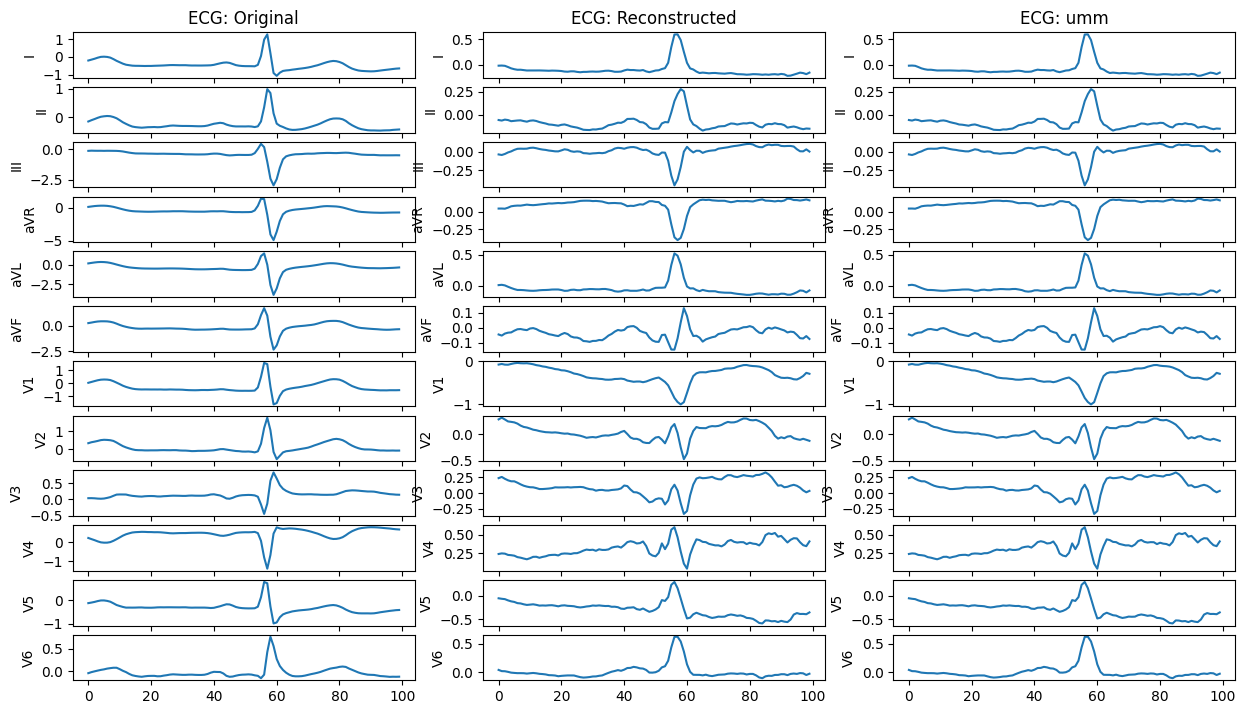

In [141]:
# build the encoder
inputs = keras.Input(shape=X_train.shape[1:])
latent_shape = keras.Input(shape=(256,))

enc = encoder(inputs, latent_dim=256)
dec = decoder(latent_shape, latent_dim=256)

enc_model = keras.Model(inputs=inputs, outputs=enc)
dec_model = keras.Model(inputs=latent_shape, outputs=dec)

enc_model.compile(optimizer='adam', loss='mse')
dec_model.compile(optimizer='adam', loss='mse')

# load first 7 layers from the trained model

for i in range(19):
    print(enc_model.layers[i].name, model.layers[i].name)
    enc_model.layers[i].set_weights(model.layers[i].get_weights())
    # dec_model.layers[i].set_weights(model.layers[i].get_weights())
    
for i in range(19, 32):
    print(dec_model.layers[i-18].name, model.layers[i].name)
    dec_model.layers[i-18].set_weights(model.layers[i].get_weights())

enc_model.summary()
dec_model.summary()


random_sample = random.choice(X_train)

latent = enc_model.predict(random_sample[None, ...])
reconstructed_sample = dec_model.predict(latent)[0]

umm = model.predict(random_sample[None, ...])[0]

dv.plot_12_lead_ecgs([random_sample, reconstructed_sample, umm], ['Original', 'Reconstructed', 'umm'])

In [142]:
# smote per fold

# empty arrays to store the resampled data of shape (0, 100, 12)
Resampled_X_train = np.array([], dtype=np.float32).reshape(0, 100, 12)
Resampled_Y_train = np.array([], dtype=bool).reshape(0,)
Resampled_folds_train = np.array([], dtype=int).reshape(0,)

new_X_train = np.array([], dtype=np.float32).reshape(0, 100, 12)

for k in range(8):
    # get the fold samples + labels
    X_fold = X_train[folds_train == k]
    Y_fold = Y_train[folds_train == k]
    
    # get the latent representation
    X_representation = enc_model.predict(X_fold)
    
    # resample using SMOTE on the latent representation
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_resampled_representation, y_resampled_fold = smote.fit_resample(X_representation, Y_fold)
    
    # decode the resampled representation
    X_resampled_fold = dec_model.predict(X_resampled_representation)
    
    folds = np.full((X_resampled_fold.shape[0],), k)

    print(f"\nFold {k} shape:           {X_fold.shape}")
    print(f"Resampled Fold {k} shape: {X_resampled_fold.shape}")
    print(f"Fold {k} class distribution:           {np.bincount(Y_fold)}")
    print(f"Resampled Fold {k} class distribution: {np.bincount(y_resampled_fold)}")

    
    # concatenate the resampled fold with the original data
    Resampled_X_train = np.concatenate([Resampled_X_train, X_resampled_fold])
    Resampled_Y_train = np.concatenate([Resampled_Y_train, y_resampled_fold])
    Resampled_folds_train = np.concatenate([Resampled_folds_train, folds])
    
    # store the newly generated data
    new_X_train = np.concatenate([new_X_train, X_resampled_fold[X_fold.shape[0]:]])
    
    
print(X_train.shape, Y_train.shape, folds_train.shape)
print(Resampled_X_train.shape, Resampled_Y_train.shape, Resampled_folds_train.shape)
print(new_X_train.shape)

56/56 [==============================] - 0s 989us/step

Fold 0 shape:           (1114, 100, 12)
Resampled Fold 0 shape: (1786, 100, 12)
Fold 0 class distribution:           [893 221]
Resampled Fold 0 class distribution: [893 893]
50/50 [==============================] - 0s 883us/step

Fold 1 shape:           (1053, 100, 12)
Resampled Fold 1 shape: (1580, 100, 12)
Fold 1 class distribution:           [790 263]
Resampled Fold 1 class distribution: [790 790]
48/48 [==============================] - 0s 957us/step

Fold 2 shape:           (1058, 100, 12)
Resampled Fold 2 shape: (1526, 100, 12)
Fold 2 class distribution:           [763 295]
Resampled Fold 2 class distribution: [763 763]
40/40 [==============================] - 0s 955us/step

Fold 3 shape:           (968, 100, 12)
Resampled Fold 3 shape: (1266, 100, 12)
Fold 3 class distribution:           [633 335]
Resampled Fold 3 class distribution: [633 633]
51/51 [==============================] - 0s 949us/step

Fold 4 shape:           (

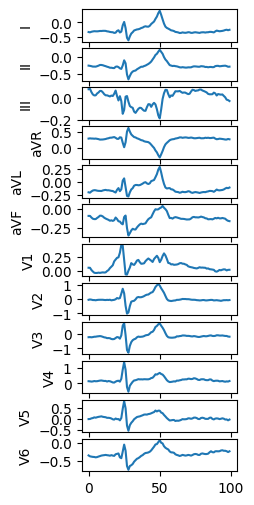

In [150]:
# visualise the newly generated data

random_sample = random.choice(new_X_train)
dv.plot_12_lead_ecg(random_sample)

In [151]:
# save the resampled data set
np.savez_compressed('data/DAT_China_1s_deep_resampled_per_fold.npz',
                    X_train=X_train, Y_train=Y_train,
                    X_train_resampled=Resampled_X_train, Y_train_resampled=Resampled_Y_train,
                    folds_train=folds_train,
                    folds_train_resampled=Resampled_folds_train,
                    X_test=X_test, Y_test=Y_test)